### Imports

In [1]:
import random
import os
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import models

from albumentations import Compose, Normalize
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import cohen_kappa_score

import cv2
import skimage.io
from PIL import Image

plt.ion()
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
from torch.utils.tensorboard import SummaryWriter

In [3]:
from chestxray.config import (PANDA_PATH,
                              PANDA_IMGS,
                              PANDA_MASKS,
                              TRAIN_CSV)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
device

device(type='cuda', index=0)

In [6]:
print(torch.cuda.get_device_properties(device))

_CudaDeviceProperties(name='GeForce RTX 2070 SUPER', major=7, minor=5, total_memory=7979MB, multi_processor_count=40)


### Config

In [7]:
class CFG:
    debug=True
    img_height = 512
    img_width = 512
    lr=3e-4
    batch_size = 16
    epoch=5
    seed=1982
    target_size=6
    img_id_col = 'image_id'
    isup_col ='isup_grade'
    n_fold=4

### Fix Random Seed

In [8]:
def seed_torch(seed=1982):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_torch()

### Load Data

In [9]:
TRAIN_DF = pd.read_csv(TRAIN_CSV)
TRAIN_DF.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


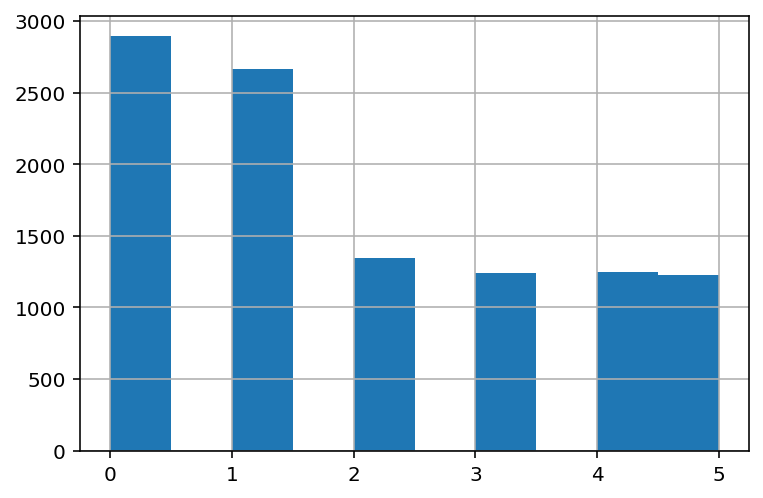

In [10]:
_ = TRAIN_DF[CFG.isup_col].hist()

### Pytorch Datasets and Dataloaders

#### Transforms

In [11]:
def get_transforms(*, data):
    
    assert data in ('train', 'valid')
    
    if data == 'train':
        return Compose([
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
    
    elif data == 'valid':
        return Compose([
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

In [12]:
class ZeroDataset(Dataset):
    def __init__(self, length):
        self.length = length
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        zero_img  = torch.zeros(3, 256, 256, dtype=torch.float32)
        label = np.random.randint(0, CFG.target_size)# random labels
        return zero_img, label

In [13]:
class TrainDataset(Dataset):
    def __init__(self, df, transform=None, debug=CFG.debug):
        self.df = df
        self.labels = df[CFG.isup_col].values
        self.transform = transform
        self.debug = debug
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_id = self.df[CFG.img_id_col].values[idx]
        file_path = f"{PANDA_IMGS}/{file_id}.tiff"
        image = skimage.io.MultiImage(file_path)
        image = cv2.resize(image[-1], 
                           (CFG.img_height, CFG.img_width),
                           interpolation=cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
            
        label = self.labels[idx]
        
        item = (image, label)
        if self.debug:
            item = (image, label, file_id)
        
        return item

#### Datasets Sanity Check

In [18]:
if CFG.debug:
    train = TRAIN_DF.sample(n=500, random_state=CFG.seed).reset_index(drop=True).copy()
else:
    train = TRAIN_DF.copy()

In [19]:
debug_dataset = TrainDataset(train, transform=get_transforms(data="train"))
debug_loader = DataLoader(debug_dataset, batch_size=CFG.batch_size, 
                          shuffle=False, num_workers=8)

In [20]:
imgs, lbls, ids = next(iter(debug_loader))

In [21]:
print(f"Images: {imgs.shape, imgs.dtype}.")
print(f"Labels: {lbls.shape, lbls.dtype}.")

Images: (torch.Size([16, 3, 512, 512]), torch.float32).
Labels: (torch.Size([16]), torch.int64).


In [22]:
# sanity check for shuffle
all(train.loc[train[CFG.img_id_col] == img_id, CFG.isup_col].values[0] == label
       for img_id, label in zip(ids, lbls.numpy()))

True

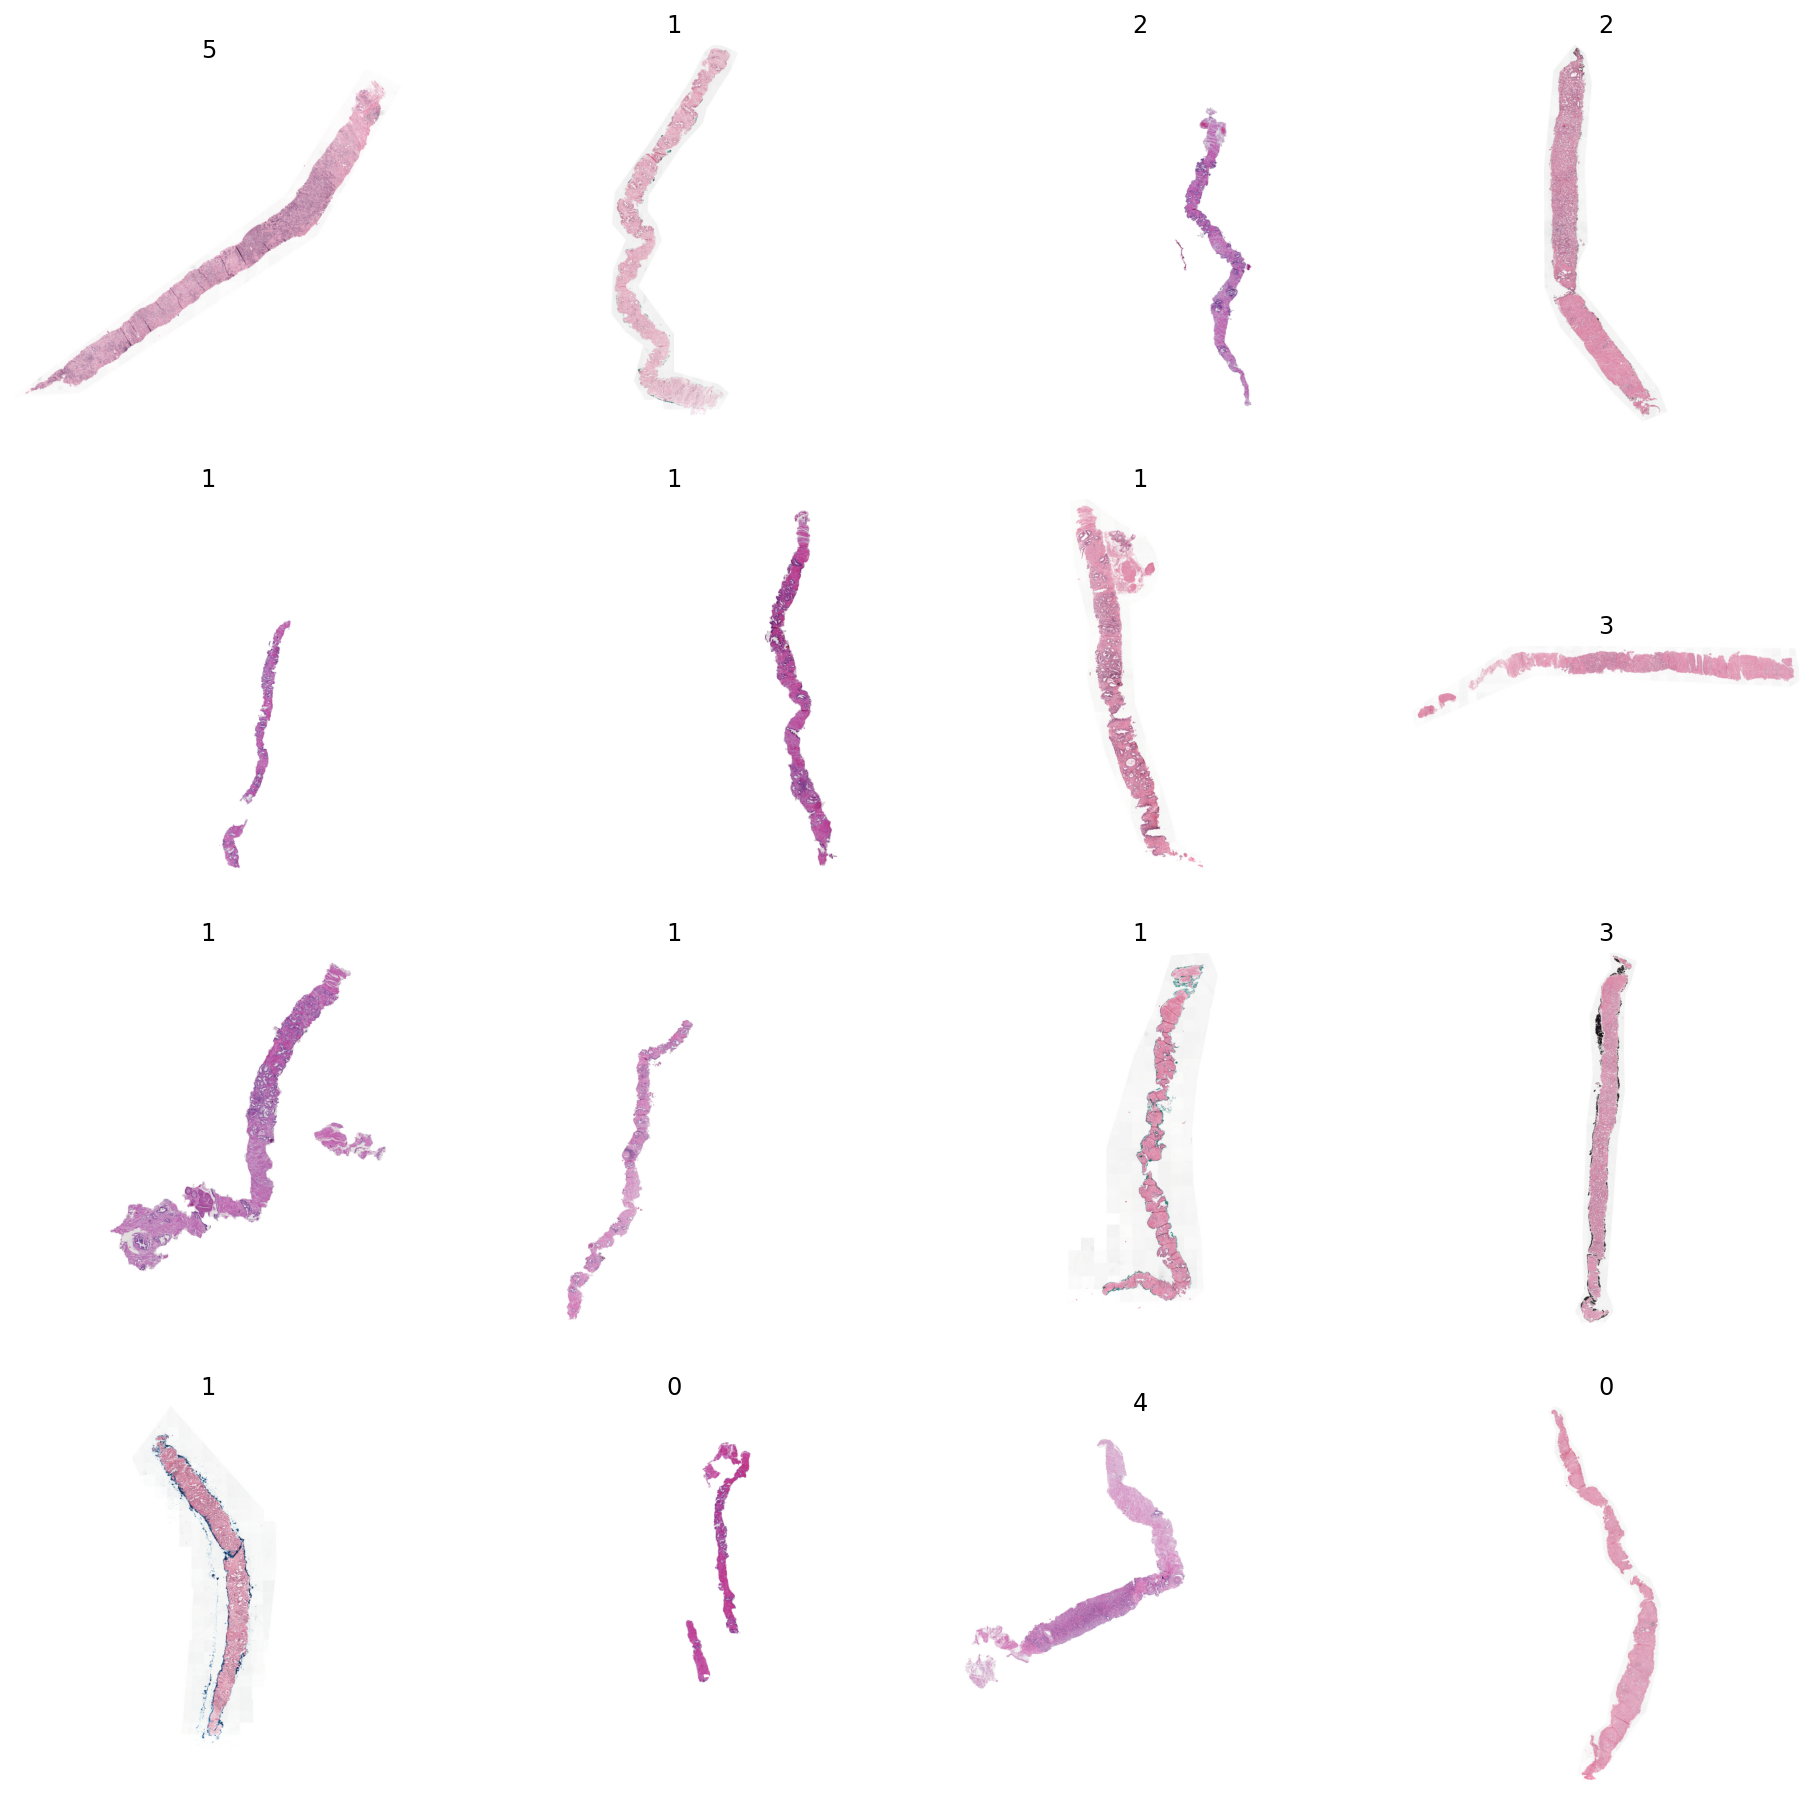

In [23]:
def show_from_ids(ids):
    labels = [train.loc[train[CFG.img_id_col] == img_id, CFG.isup_col].values[0] for img_id in ids]
    paths = [f"{PANDA_IMGS}/{img_id}.tiff" for img_id in ids]
    plt.figure(figsize=(16,16))
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        img = skimage.io.MultiImage(paths[n])[-1]
        plt.imshow(img)
        plt.title(labels[n])
        plt.axis('off')
        
show_from_ids(ids)

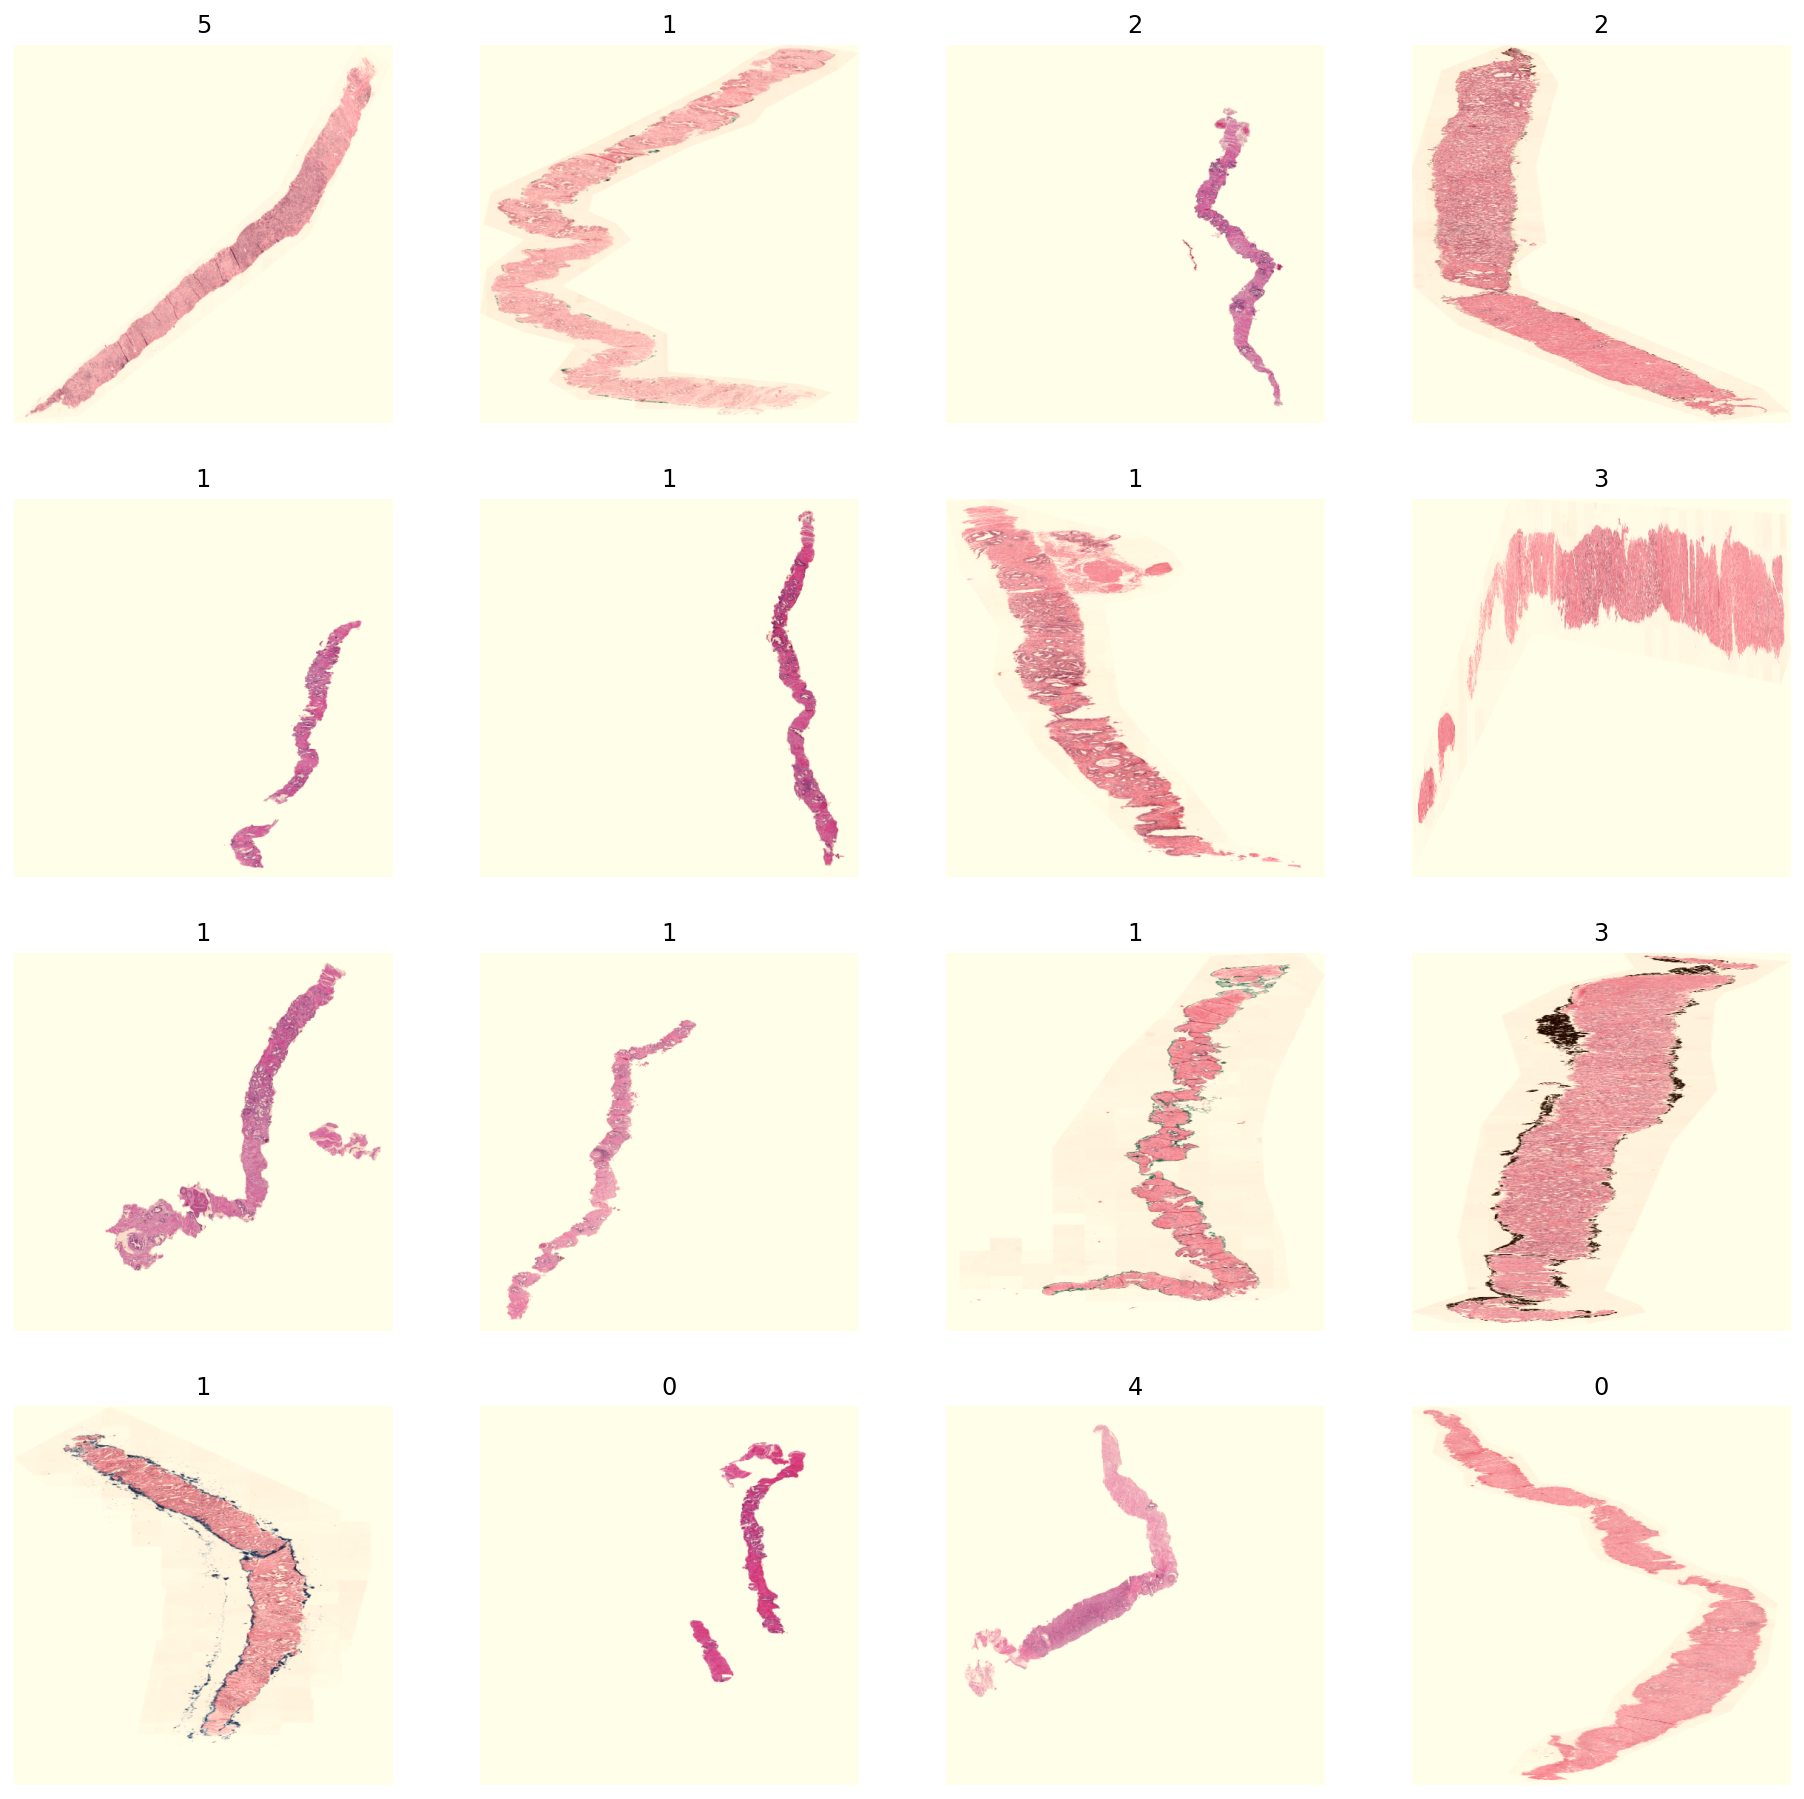

In [24]:
# Sanity visualisation
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(16,16))
    for n in range(16):
        ax = plt.subplot(4,4,n+1)
        img = image_batch[n]
        # Reverse all preprocessing
        img = img.numpy().transpose((1, 2, 0))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(label_batch[n].numpy())
        plt.axis('off')
        

show_batch(imgs, lbls)

### Model Sanity Check

In [19]:
# according http://karpathy.github.io/2019/04/25/recipe/

In [20]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, CFG.target_size)

#### Model Definitions

In [14]:
# Convolutional neural network (two convolutional layers) - tiny ConvNet
class TinyConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(TinyConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.avgpool(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [15]:
# Convolutional neural network (two convolutional layers) - tiny ConvNet
class TinyV2ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(TinyV2ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(256, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [27]:
model = TinyV2ConvNet(num_classes=CFG.target_size)

In [28]:
print(model)

TinyV2ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), st

In [29]:
# Number of trainable parameters
def trainable_params(model):
    result = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model has: {result} trainable parameters")

In [30]:
trainable_params(model)

Model has: 1080582 trainable parameters


In [31]:
# writer.add_graph(model, imgs)
# writer.close()

#### Loss @ Init

In [32]:
def cce_loss_at_init(model, num_classes):
    criterion = nn.CrossEntropyLoss()
    input = torch.randn(64, 3, 256, 256, requires_grad=True)
    target = torch.empty(64, dtype=torch.long).random_(num_classes)
    model.eval();
    output = model(input)
    loss = criterion(output, target)
    print(f"CCE loss @ init: {loss} -- -log(1/{num_classes} classes): {-np.log(1/num_classes)}")

In [33]:
cce_loss_at_init(model, 6)

CCE loss @ init: 1.7838292121887207 -- -log(1/6 classes): 1.791759469228055


#### Correct Bias Init Check

In [34]:
# init well - set bias to predict inbalanced class probabilities
cls_probas = (TRAIN_DF[CFG.isup_col].value_counts() / len(TRAIN_DF)).values
# should init output layer bias like this 
out_layer_bias = np.log(cls_probas)

In [35]:
# initialize bias of the final layer to represent class probas we have in data
# check if it works
def check_final_linear_bias_init(model, cls_probas):
    input = torch.randn(64, 3, 256, 256, requires_grad=False)
    out_layer_bias = np.log(cls_probas)
    # change bias of the final linear 
    list(model.modules())[-1].bias.data = torch.tensor(out_layer_bias, 
                                                       dtype=list(model.modules())[-1].bias.data.dtype)
    model.eval();
    output = model(input)
    print(f"Class probabilities:\n {cls_probas}")
    print(f"Softmax on output logits:\n {nn.functional.softmax(output, dim=1).data[:5]}")

In [36]:
model = TinyConvNet(CFG.target_size)
check_final_linear_bias_init(model, cls_probas)

Class probabilities:
 [0.27241899 0.25113037 0.12650716 0.1176526  0.11699322 0.11529766]
Softmax on output logits:
 tensor([[0.2437, 0.3056, 0.1343, 0.0879, 0.0972, 0.1313],
        [0.2435, 0.3056, 0.1345, 0.0878, 0.0972, 0.1314],
        [0.2441, 0.3051, 0.1345, 0.0878, 0.0971, 0.1316],
        [0.2437, 0.3053, 0.1341, 0.0879, 0.0973, 0.1316],
        [0.2440, 0.3053, 0.1341, 0.0879, 0.0973, 0.1314]])


In [37]:
model.fc.bias

Parameter containing:
tensor([-1.3004, -1.3818, -2.0675, -2.1400, -2.1456, -2.1602],
       requires_grad=True)

#### Tensorbord Writer and Visualisations

In [16]:
def reverse_show_img(img):
    # Reverse all preprocessing
    img = img.numpy().transpose((1, 2, 0))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

In [92]:
img = reverse_show_img(imgs[0])

In [17]:
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/test-run')

In [74]:
# write to tensorboard
# writer.add_image("test-img1", img, dataformats="HWC")
# writer.close()

In [75]:
# write to tensorboard
# writer.add_image("test-img2", imgs[0])
# writer.close()

In [18]:
# helper functions

def output_to_probs(output):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(output, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "output_to_probs" function.
    '''
    preds, probs = output_to_probs(output)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 12))
    for idx in np.arange(6):
        ax = fig.add_subplot(1, 6, idx+1, xticks=[], yticks=[])
        plt.imshow(reverse_show_img(images[idx]))
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            preds[idx],
            probs[idx] * 100.0,
            labels[idx]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    plt.tight_layout()
    return fig

In [41]:
model = TinyV2ConvNet(CFG.target_size)
model.eval();
output = model(imgs)

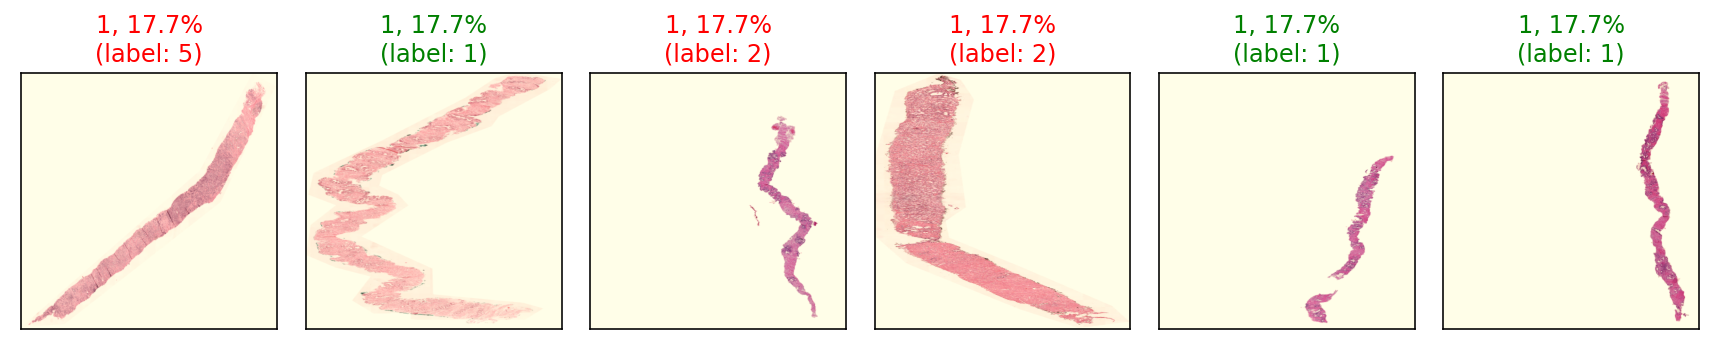

In [42]:
_ = plot_classes_preds(output, imgs, lbls)

#### Input-Indepent Baseline

In [19]:
def train_only(dataset, model, optimizer, criterion, batch_sz=CFG.batch_size, num_epochs=25):
    # define a data loader
    dataloader = DataLoader(dataset, batch_size=batch_sz, shuffle=True, num_workers=6)
    model.to(device)
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        running_loss = 0.0
        # create random step
        rand_step = np.random.randint(0, len(dataloader))
        epoch_preds = []
        epoch_labels = []
        # Iterate over data.
        tk_train = tqdm(enumerate(dataloader), total=len(dataloader))
        for i, data in tk_train:
            # Calculate global step
            glob_step = epoch * len(dataloader) + i
            # Set training mode
            model.train();
            inputs, labels = data
            # Visualize input to the model:
            if i == rand_step:
                img = reverse_show_img(inputs[0])
                writer.add_image(tag="Input Image", img_tensor=img, 
                                 global_step=glob_step, dataformats="HWC")
            
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # loss is mean across batch, multiply by batch size
            # divide by number of steps in epoch (so loss is normalized)
            running_loss += loss.item() / len(dataloader)
            # tensorboard
            writer.add_scalar(tag="Training loss", scalar_value=loss.item(), 
                              global_step=glob_step)
            
            # collect preds and labels for QWK
            epoch_preds.append(outputs.data.to('cpu').numpy().argmax(1))
            epoch_labels.append(labels.to('cpu').numpy())
        
        epoch_loss = running_loss
        print(f'Loss: {epoch_loss:.4f}')
        
        # Calculate epoch QWK and preds distribution
        epoch_preds = np.concatenate(epoch_preds)
        epoch_labels = np.concatenate(epoch_labels)
        print(f'Counter preds: {Counter(epoch_preds)}')
        qwk = cohen_kappa_score(epoch_preds, epoch_labels, weights='quadratic')
        print(f"Epoch QWK: {qwk:.3f}")
        writer.add_scalar(tag="Training QWK", scalar_value=qwk, 
                              global_step=epoch)
        
        # write imgs and predictions to the Tensorboard
        # it is last batch
        with torch.no_grad():
            model.eval();
            output = model(inputs)
            output = output.to("cpu")
            inputs = inputs.to("cpu")
            labels = labels.to("cpu")
            writer.add_figure(tag="Actuals vs Predictions", 
                              figure=plot_classes_preds(output, inputs, labels), 
                              global_step=glob_step)
            
    writer.close()

In [64]:
zero_ds = ZeroDataset(500)
zero_loader = DataLoader(zero_ds, batch_size=CFG.batch_size, num_workers=6)

In [65]:
model = TinyConvNet(CFG.target_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr, amsgrad=False)

In [66]:
train_only(zero_ds, model, optimizer, criterion, num_epochs=5)

Epoch 0/4
----------
Last batch labels: [4 0 4 3]
Last batch predictions: [4 4 4 4]
Loss: 1.7967
Epoch 1/4
----------
Last batch labels: [4 0 4 3]
Last batch predictions: [4 4 4 4]
Loss: 1.7959
Epoch 2/4
----------
Last batch labels: [4 0 4 3]
Last batch predictions: [4 4 4 4]
Loss: 1.7954
Epoch 3/4
----------
Last batch labels: [4 0 4 3]
Last batch predictions: [4 4 4 4]
Loss: 1.7949
Epoch 4/4
----------
Last batch labels: [4 0 4 3]
Last batch predictions: [4 4 4 4]
Loss: 1.7944


#### Overfit One Batch

In [20]:
if CFG.debug:
    train = TRAIN_DF.sample(n=6, random_state=CFG.seed).reset_index(drop=True).copy()

In [21]:
one_batch_ds = TrainDataset(train, transform=get_transforms(data="train"), debug=False)

In [22]:
model = TinyV2ConvNet(CFG.target_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr, amsgrad=False)

In [70]:
train_only(one_batch_ds, model, optimizer, criterion, batch_sz=len(one_batch_ds), num_epochs=100)

Epoch 0/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


Loss: 1.7861
Counter preds: Counter({1: 4, 0: 2})
Epoch QWK: 0.062
Epoch 1/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


Loss: 1.4347
Counter preds: Counter({1: 5, 2: 1})
Epoch QWK: 0.118
Epoch 2/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


Loss: 1.2713
Counter preds: Counter({1: 5, 2: 1})
Epoch QWK: 0.118
Epoch 3/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Loss: 1.1650
Counter preds: Counter({1: 5, 2: 1})
Epoch QWK: 0.118
Epoch 4/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


Loss: 1.0770
Counter preds: Counter({1: 5, 2: 1})
Epoch QWK: 0.118
Epoch 5/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


Loss: 0.9972
Counter preds: Counter({1: 5, 2: 1})
Epoch QWK: 0.118
Epoch 6/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Loss: 0.9312
Counter preds: Counter({1: 4, 5: 1, 2: 1})
Epoch QWK: 0.857
Epoch 7/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


Loss: 0.8656
Counter preds: Counter({1: 4, 2: 1, 5: 1})
Epoch QWK: 0.857
Epoch 8/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Loss: 0.8042
Counter preds: Counter({1: 4, 2: 1, 5: 1})
Epoch QWK: 0.857
Epoch 9/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Loss: 0.7463
Counter preds: Counter({1: 4, 2: 1, 5: 1})
Epoch QWK: 0.857
Epoch 10/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


Loss: 0.6919
Counter preds: Counter({1: 4, 5: 1, 2: 1})
Epoch QWK: 0.857
Epoch 11/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Loss: 0.6446
Counter preds: Counter({1: 4, 5: 1, 2: 1})
Epoch QWK: 0.857
Epoch 12/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


Loss: 0.6023
Counter preds: Counter({1: 4, 2: 1, 5: 1})
Epoch QWK: 0.857
Epoch 13/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


Loss: 0.5619
Counter preds: Counter({1: 4, 5: 1, 2: 1})
Epoch QWK: 0.857
Epoch 14/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Loss: 0.5232
Counter preds: Counter({1: 4, 2: 1, 5: 1})
Epoch QWK: 0.857
Epoch 15/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Loss: 0.4874
Counter preds: Counter({1: 4, 5: 1, 2: 1})
Epoch QWK: 0.857
Epoch 16/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Loss: 0.4569
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 17/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


Loss: 0.4441
Counter preds: Counter({1: 4, 5: 1, 2: 1})
Epoch QWK: 0.857
Epoch 18/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


Loss: 0.4577
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 19/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


Loss: 0.3980
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 20/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


Loss: 0.4047
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 21/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


Loss: 0.3527
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 22/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


Loss: 0.3559
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 23/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


Loss: 0.3327
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 24/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


Loss: 0.2959
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 25/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Loss: 0.2989
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 26/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


Loss: 0.2641
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 27/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


Loss: 0.2598
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 28/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Loss: 0.2381
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 29/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


Loss: 0.2307
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 30/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


Loss: 0.2132
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 31/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


Loss: 0.2029
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 32/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


Loss: 0.1924
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 33/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


Loss: 0.1792
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 34/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


Loss: 0.1728
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 35/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Loss: 0.1584
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 36/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


Loss: 0.1536
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 37/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


Loss: 0.1433
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 38/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


Loss: 0.1372
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 39/99
----------


100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


Loss: 0.1329
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 40/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


Loss: 0.1206
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 41/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


Loss: 0.1197
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 42/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Loss: 0.1104
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 43/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


Loss: 0.1066
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 44/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


Loss: 0.1047
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 45/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


Loss: 0.0972
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 46/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


Loss: 0.0932
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 47/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


Loss: 0.0899
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 48/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Loss: 0.0852
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 49/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


Loss: 0.0819
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 50/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


Loss: 0.0793
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 51/99
----------


100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Loss: 0.0767
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 52/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Loss: 0.0728
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 53/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


Loss: 0.0717
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 54/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


Loss: 0.0686
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 55/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


Loss: 0.0649
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 56/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


Loss: 0.0635
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 57/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Loss: 0.0614
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 58/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


Loss: 0.0586
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 59/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


Loss: 0.0577
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 60/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


Loss: 0.0562
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 61/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


Loss: 0.0540
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 62/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


Loss: 0.0525
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 63/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


Loss: 0.0511
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 64/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


Loss: 0.0498
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 65/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


Loss: 0.0479
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 66/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Loss: 0.0471
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 67/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


Loss: 0.0458
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 68/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


Loss: 0.0443
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 69/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


Loss: 0.0434
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 70/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


Loss: 0.0427
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 71/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


Loss: 0.0416
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 72/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


Loss: 0.0404
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 73/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


Loss: 0.0395
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 74/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


Loss: 0.0386
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 75/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


Loss: 0.0378
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 76/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


Loss: 0.0366
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 77/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


Loss: 0.0360
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 78/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


Loss: 0.0352
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 79/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Loss: 0.0344
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 80/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


Loss: 0.0336
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 81/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Loss: 0.0330
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 82/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


Loss: 0.0325
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 83/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


Loss: 0.0318
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 84/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


Loss: 0.0310
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 85/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


Loss: 0.0304
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 86/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


Loss: 0.0299
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 87/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


Loss: 0.0293
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 88/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Loss: 0.0288
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 89/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Loss: 0.0282
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 90/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Loss: 0.0276
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 91/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


Loss: 0.0272
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 92/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


Loss: 0.0268
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 93/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Loss: 0.0265
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 94/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


Loss: 0.0260
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 95/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


Loss: 0.0255
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 96/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


Loss: 0.0250
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 97/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


Loss: 0.0245
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 98/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


Loss: 0.0240
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000
Epoch 99/99
----------


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Loss: 0.0237
Counter preds: Counter({1: 3, 2: 2, 5: 1})
Epoch QWK: 1.000


### Train Eval Loop

In [ ]:
# TODO: save best model, add bias init (models), CV-folds

In [24]:
def train_eval_loop(train_dataset, val_dataset, model, optimizer, criterion, batch_sz=CFG.batch_size, num_epochs=CFG.epoch):
    # define a data loader
    train_dataloader = DataLoader(train_dataset, batch_size=batch_sz, shuffle=True, num_workers=6)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_sz, shuffle=False, num_workers=6)
    model.to(device)
    
    # Define epochs numbers to look into input images and predictions
    # No more than 10 times per full training
    vis_step = np.ceil(num_epochs/10).astype(int)
    visual_epochs = list(range(0, num_epochs, vis_step))
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        # Training Phase
        # Set training mode
        model.train();
        train_running_loss = 0.0
        train_epoch_preds, train_epoch_labels = [], []
        # create random step
        rand_step = np.random.randint(0, len(train_dataloader))
        
        # Iterate over train data.
        tk_train = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
        for i, data in tk_train:
            # Calculate global step
            train_global_step = epoch * len(train_dataloader) + i
            
            inputs, labels = data
            # Visualize input to the model:
            if epoch in visual_epochs and i == rand_step:
                print("Visualising input")
                img = reverse_show_img(inputs[0])
                writer.add_image(tag="Input Image", img_tensor=img, global_step=train_global_step, dataformats="HWC")
                del img
            
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # loss is mean across batch, multiply by batch size
            # divide by number of steps in epoch (so loss is normalized)
            train_running_loss += loss.item() / len(train_dataloader)
            # tensorboarding loss
            writer.add_scalar(tag="Training loss", scalar_value=loss.item(), global_step=train_global_step)
            
            # collect train preds and labels for QWK
            train_epoch_preds.append(outputs.data.to('cpu').numpy().argmax(1))
            train_epoch_labels.append(labels.to('cpu').numpy())
        
        # Validation Phase
        # Set evaluation mode
        model.eval();
        val_running_loss = 0.0
        val_epoch_preds, val_epoch_labels = [], []
        # Iterate over val data
        tk_val = tqdm(enumerate(val_dataloader), total=len(val_dataloader))
        for j, data in tk_val:
            # Calculate global step
            val_global_step = epoch * len(val_dataloader) + j
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() / len(val_dataloader)
            # tensorboarding loss
            writer.add_scalar(tag="Validation loss", scalar_value=loss.item(), global_step=val_global_step)
            
            # collect validation preds and labels for QWK
            val_epoch_preds.append(outputs.data.to('cpu').numpy().argmax(1))
            val_epoch_labels.append(labels.to('cpu').numpy())
            
            # visualise predictions for 0th validation batch
            if epoch in visual_epochs and j == 0:
                writer.add_figure(tag="Actuals vs Predictions", figure=plot_classes_preds(outputs.to('cpu'), inputs.to('cpu'), labels.to('cpu')), 
                                  global_step=val_global_step)
        
        # "End of Epoch" Phase
        print(f'Training Loss: {train_running_loss:.4f}\tValidation Loss: {val_running_loss:.4f}')
        
        # Calculate epoch QWK and preds distribution
        train_epoch_preds = np.concatenate(train_epoch_preds)
        train_epoch_labels = np.concatenate(train_epoch_labels)
        val_epoch_preds = np.concatenate(val_epoch_preds)
        val_epoch_labels = np.concatenate(val_epoch_labels)
        print(f'Counter train preds: {Counter(train_epoch_preds)}\tCounter val preds: {Counter(val_epoch_preds)}')
        
        train_qwk = cohen_kappa_score(train_epoch_preds, train_epoch_labels, weights='quadratic')
        val_qwk = cohen_kappa_score(val_epoch_preds, val_epoch_labels, weights='quadratic')
        print(f"Epoch train QWK: {train_qwk:.3f}\tval QWK: {val_qwk:.3f}")
        writer.add_scalar(tag="Training QWK", scalar_value=train_qwk, global_step=epoch)
        writer.add_scalar(tag="Validation QWK", scalar_value=val_qwk, global_step=epoch)
    
    writer.close()
    return model

In [25]:
_ = train_eval_loop(one_batch_ds, one_batch_ds, model, optimizer, criterion, batch_sz=len(one_batch_ds), num_epochs=100)

Epoch 0/99
----------


100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

Visualising input


100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

Training Loss: 1.4829	Validation Loss: 1.6408
Counter train preds: Counter({1: 6})	Counter val preds: Counter({2: 6})
Epoch train QWK: 0.000	val QWK: 0.000
Epoch 1/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

Training Loss: 1.2325	Validation Loss: 1.5919
Counter train preds: Counter({1: 4, 2: 2})	Counter val preds: Counter({2: 6})
Epoch train QWK: -0.125	val QWK: 0.000
Epoch 2/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

Training Loss: 1.1099	Validation Loss: 1.5928
Counter train preds: Counter({1: 5, 2: 1})	Counter val preds: Counter({2: 6})
Epoch train QWK: 0.118	val QWK: 0.000
Epoch 3/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

Training Loss: 1.0199	Validation Loss: 1.6224
Counter train preds: Counter({1: 5, 2: 1})	Counter val preds: Counter({2: 6})
Epoch train QWK: 0.118	val QWK: 0.000
Epoch 4/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

Training Loss: 0.9375	Validation Loss: 1.6612
Counter train preds: Counter({1: 5, 2: 1})	Counter val preds: Counter({2: 6})
Epoch train QWK: 0.118	val QWK: 0.000
Epoch 5/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

Training Loss: 0.8691	Validation Loss: 1.6828
Counter train preds: Counter({1: 5, 2: 1})	Counter val preds: Counter({2: 6})
Epoch train QWK: 0.118	val QWK: 0.000
Epoch 6/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

Training Loss: 0.8082	Validation Loss: 1.6743
Counter train preds: Counter({1: 5, 2: 1})	Counter val preds: Counter({2: 6})
Epoch train QWK: 0.118	val QWK: 0.000
Epoch 7/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

Training Loss: 0.7503	Validation Loss: 1.6386
Counter train preds: Counter({1: 4, 2: 1, 5: 1})	Counter val preds: Counter({2: 6})
Epoch train QWK: 0.857	val QWK: 0.000
Epoch 8/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

Training Loss: 0.6927	Validation Loss: 1.5906
Counter train preds: Counter({1: 4, 2: 1, 5: 1})	Counter val preds: Counter({2: 6})
Epoch train QWK: 0.857	val QWK: 0.000
Epoch 9/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

Training Loss: 0.6356	Validation Loss: 1.5340
Counter train preds: Counter({1: 4, 5: 1, 2: 1})	Counter val preds: Counter({2: 6})
Epoch train QWK: 0.857	val QWK: 0.000
Epoch 10/99
----------



100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

Visualising input



100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

Training Loss: 0.5793	Validation Loss: 1.4595
Counter train preds: Counter({1: 4, 5: 1, 2: 1})	Counter val preds: Counter({2: 6})
Epoch train QWK: 0.857	val QWK: 0.000
Epoch 11/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.47it/s]

Training Loss: 0.5264	Validation Loss: 1.3860
Counter train preds: Counter({1: 4, 5: 1, 2: 1})	Counter val preds: Counter({1: 3, 2: 3})
Epoch train QWK: 0.857	val QWK: -0.400
Epoch 12/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

Training Loss: 0.5145	Validation Loss: 1.3343
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 6})
Epoch train QWK: 1.000	val QWK: 0.000
Epoch 13/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

Training Loss: 0.5054	Validation Loss: 1.3296
Counter train preds: Counter({1: 4, 2: 1, 5: 1})	Counter val preds: Counter({1: 6})
Epoch train QWK: 0.857	val QWK: 0.000
Epoch 14/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

Training Loss: 0.4404	Validation Loss: 1.3678
Counter train preds: Counter({1: 4, 5: 1, 2: 1})	Counter val preds: Counter({1: 6})
Epoch train QWK: 0.857	val QWK: 0.000
Epoch 15/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.31it/s]

Training Loss: 0.4019	Validation Loss: 1.3886
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 6})
Epoch train QWK: 1.000	val QWK: 0.000
Epoch 16/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

Training Loss: 0.4006	Validation Loss: 1.3875
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 6})
Epoch train QWK: 1.000	val QWK: 0.000
Epoch 17/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

Training Loss: 0.3387	Validation Loss: 1.4172
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 6})
Epoch train QWK: 1.000	val QWK: 0.000
Epoch 18/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

Training Loss: 0.3230	Validation Loss: 1.5343
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 6})
Epoch train QWK: 1.000	val QWK: 0.000
Epoch 19/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

Training Loss: 0.3019	Validation Loss: 1.6765
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 6})
Epoch train QWK: 1.000	val QWK: 0.000
Epoch 20/99
----------



100%|██████████| 1/1 [00:00<00:00,  3.15it/s]

Visualising input


100%|██████████| 1/1 [00:00<00:00,  1.94it/s]

Training Loss: 0.2651	Validation Loss: 1.7301
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 6})
Epoch train QWK: 1.000	val QWK: 0.000
Epoch 21/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.14it/s]

Training Loss: 0.2634	Validation Loss: 1.7114
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 6})
Epoch train QWK: 1.000	val QWK: 0.000
Epoch 22/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

Training Loss: 0.2271	Validation Loss: 1.7653
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 6})
Epoch train QWK: 1.000	val QWK: 0.000
Epoch 23/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.18it/s]

Training Loss: 0.2227	Validation Loss: 1.8919
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 6})
Epoch train QWK: 1.000	val QWK: 0.000
Epoch 24/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.12it/s]

Training Loss: 0.2004	Validation Loss: 2.0158
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 6})
Epoch train QWK: 1.000	val QWK: 0.000
Epoch 25/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

Training Loss: 0.1910	Validation Loss: 2.1697
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 6})
Epoch train QWK: 1.000	val QWK: 0.000
Epoch 26/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.47it/s]

Training Loss: 0.1775	Validation Loss: 2.4404
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 6})
Epoch train QWK: 1.000	val QWK: 0.000
Epoch 27/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

Training Loss: 0.1608	Validation Loss: 2.8393
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 6})
Epoch train QWK: 1.000	val QWK: 0.000
Epoch 28/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

Training Loss: 0.1558	Validation Loss: 3.1727
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 6})
Epoch train QWK: 1.000	val QWK: 0.000
Epoch 29/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

Training Loss: 0.1401	Validation Loss: 3.3119
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 6})
Epoch train QWK: 1.000	val QWK: 0.000
Epoch 30/99
----------



100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

Visualising input



100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

Training Loss: 0.1341	Validation Loss: 3.3113
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 6})
Epoch train QWK: 1.000	val QWK: 0.000
Epoch 31/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

Training Loss: 0.1268	Validation Loss: 3.2834
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 6})
Epoch train QWK: 1.000	val QWK: 0.000
Epoch 32/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

Training Loss: 0.1158	Validation Loss: 3.1641
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 6})
Epoch train QWK: 1.000	val QWK: 0.000
Epoch 33/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

Training Loss: 0.1125	Validation Loss: 2.9617
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 6})
Epoch train QWK: 1.000	val QWK: 0.000
Epoch 34/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.21it/s]

Training Loss: 0.1033	Validation Loss: 2.8008
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 6})
Epoch train QWK: 1.000	val QWK: 0.000
Epoch 35/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.31it/s]

Training Loss: 0.0988	Validation Loss: 2.9200
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 6})
Epoch train QWK: 1.000	val QWK: 0.000
Epoch 36/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

Training Loss: 0.0935	Validation Loss: 3.0086
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 6})
Epoch train QWK: 1.000	val QWK: 0.000
Epoch 37/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

Training Loss: 0.0871	Validation Loss: 2.7797
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 6})
Epoch train QWK: 1.000	val QWK: 0.000
Epoch 38/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

Training Loss: 0.0838	Validation Loss: 2.3265
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 6})
Epoch train QWK: 1.000	val QWK: 0.000
Epoch 39/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.36it/s]

Training Loss: 0.0788	Validation Loss: 1.9470
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 6})
Epoch train QWK: 1.000	val QWK: 0.000
Epoch 40/99
----------



100%|██████████| 1/1 [00:00<00:00,  3.24it/s]

Visualising input


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]

Training Loss: 0.0763	Validation Loss: 2.0506
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 6})
Epoch train QWK: 1.000	val QWK: 0.000
Epoch 41/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

Training Loss: 0.0719	Validation Loss: 2.1449
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 6})
Epoch train QWK: 1.000	val QWK: 0.000
Epoch 42/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.39it/s]

Training Loss: 0.0692	Validation Loss: 1.7972
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 6})
Epoch train QWK: 1.000	val QWK: 0.000
Epoch 43/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

Training Loss: 0.0650	Validation Loss: 1.3855
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 6})
Epoch train QWK: 1.000	val QWK: 0.000
Epoch 44/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

Training Loss: 0.0632	Validation Loss: 1.5152
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 6})
Epoch train QWK: 1.000	val QWK: 0.000
Epoch 45/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

Training Loss: 0.0627	Validation Loss: 1.8947
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 6})
Epoch train QWK: 1.000	val QWK: 0.000
Epoch 46/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

Training Loss: 0.0597	Validation Loss: 2.1729
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 6})
Epoch train QWK: 1.000	val QWK: 0.000
Epoch 47/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.81it/s]

Training Loss: 0.0576	Validation Loss: 1.5380
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 6})
Epoch train QWK: 1.000	val QWK: 0.000
Epoch 48/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

Training Loss: 0.0524	Validation Loss: 0.7361
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 6})
Epoch train QWK: 1.000	val QWK: 0.000
Epoch 49/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.39it/s]

Training Loss: 0.0529	Validation Loss: 0.7513
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 6})
Epoch train QWK: 1.000	val QWK: 0.000
Epoch 50/99
----------



100%|██████████| 1/1 [00:00<00:00,  3.23it/s]

Visualising input


100%|██████████| 1/1 [00:00<00:00,  1.95it/s]

Training Loss: 0.0520	Validation Loss: 0.9340
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 6})
Epoch train QWK: 1.000	val QWK: 0.000
Epoch 51/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

Training Loss: 0.0473	Validation Loss: 0.8254
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 6})
Epoch train QWK: 1.000	val QWK: 0.000
Epoch 52/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

Training Loss: 0.0479	Validation Loss: 0.4630
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 5, 2: 1})
Epoch train QWK: 1.000	val QWK: 0.118
Epoch 53/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

Training Loss: 0.0457	Validation Loss: 0.1638
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 54/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

Training Loss: 0.0430	Validation Loss: 0.1378
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 55/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

Training Loss: 0.0438	Validation Loss: 0.1755
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 56/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

Training Loss: 0.0410	Validation Loss: 0.1290
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 57/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

Training Loss: 0.0399	Validation Loss: 0.0752
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 58/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.31it/s]

Training Loss: 0.0389	Validation Loss: 0.0671
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 59/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

Training Loss: 0.0367	Validation Loss: 0.0723
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 60/99
----------



100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

Visualising input



100%|██████████| 1/1 [00:00<00:00,  2.02it/s]

Training Loss: 0.0368	Validation Loss: 0.0636
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 61/99
----------



100%|██████████| 1/1 [00:00<00:00,  3.98it/s]

Training Loss: 0.0343	Validation Loss: 0.0596
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 62/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

Training Loss: 0.0348	Validation Loss: 0.0539
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 63/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.47it/s]

Training Loss: 0.0330	Validation Loss: 0.0620
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 64/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

Training Loss: 0.0323	Validation Loss: 0.0667
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 65/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

Training Loss: 0.0317	Validation Loss: 0.0583
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 66/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

Training Loss: 0.0302	Validation Loss: 0.0508
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 67/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

Training Loss: 0.0301	Validation Loss: 0.0484
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 68/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.02it/s]

Training Loss: 0.0289	Validation Loss: 0.0584
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 69/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.50it/s]

Training Loss: 0.0285	Validation Loss: 0.0718
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 70/99
----------



100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

Visualising input


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

Training Loss: 0.0276	Validation Loss: 0.0652
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 71/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.14it/s]

Training Loss: 0.0271	Validation Loss: 0.0500
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 72/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.06it/s]

Training Loss: 0.0263	Validation Loss: 0.0467
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 73/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.13it/s]

Training Loss: 0.0258	Validation Loss: 0.0580
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 74/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

Training Loss: 0.0252	Validation Loss: 0.0669
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 75/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

Training Loss: 0.0246	Validation Loss: 0.0636
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 76/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

Training Loss: 0.0242	Validation Loss: 0.0526
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 77/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.31it/s]

Training Loss: 0.0235	Validation Loss: 0.0489
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 78/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

Training Loss: 0.0232	Validation Loss: 0.0495
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 79/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.31it/s]

Training Loss: 0.0226	Validation Loss: 0.0611
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 80/99
----------



100%|██████████| 1/1 [00:00<00:00,  2.90it/s]

Visualising input



100%|██████████| 1/1 [00:00<00:00,  2.00it/s]

Training Loss: 0.0223	Validation Loss: 0.0691
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 81/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

Training Loss: 0.0218	Validation Loss: 0.0561
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 82/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

Training Loss: 0.0213	Validation Loss: 0.0446
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 83/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

Training Loss: 0.0210	Validation Loss: 0.0471
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 84/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

Training Loss: 0.0205	Validation Loss: 0.0573
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 85/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

Training Loss: 0.0202	Validation Loss: 0.0575
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 86/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

Training Loss: 0.0198	Validation Loss: 0.0491
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 87/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.35it/s]

Training Loss: 0.0195	Validation Loss: 0.0428
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 88/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

Training Loss: 0.0192	Validation Loss: 0.0398
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 89/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

Training Loss: 0.0188	Validation Loss: 0.0415
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 90/99
----------



100%|██████████| 1/1 [00:00<00:00,  3.08it/s]

Visualising input


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

Training Loss: 0.0186	Validation Loss: 0.0455
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 91/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.47it/s]

Training Loss: 0.0182	Validation Loss: 0.0409
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 92/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

Training Loss: 0.0179	Validation Loss: 0.0324
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 93/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.39it/s]

Training Loss: 0.0176	Validation Loss: 0.0293
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 94/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

Training Loss: 0.0174	Validation Loss: 0.0304
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 95/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

Training Loss: 0.0171	Validation Loss: 0.0321
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 96/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

Training Loss: 0.0168	Validation Loss: 0.0312
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 97/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

Training Loss: 0.0166	Validation Loss: 0.0273
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 98/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

Training Loss: 0.0163	Validation Loss: 0.0249
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
Epoch 99/99
----------



100%|██████████| 1/1 [00:00<00:00,  4.32it/s]

Training Loss: 0.0161	Validation Loss: 0.0248
Counter train preds: Counter({1: 3, 2: 2, 5: 1})	Counter val preds: Counter({1: 3, 2: 2, 5: 1})
Epoch train QWK: 1.000	val QWK: 1.000
